In [1]:
#These lines of code are importing various libraries and modules in Python for data manipulation,
# visualization, machine learning, and model evaluation. Here is a breakdown of each import statement:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV,RepeatedKFold
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
import xgboost as xg
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
import math

In [2]:
df=pd.read_csv("../Data/housePrice.csv")
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67
3475,83,2,True,True,True,Niavaran,6.800000e+09,226666.67
3476,75,2,False,False,False,Parand,3.650000e+08,12166.67
3477,105,2,True,True,True,Dorous,5.600000e+09,186666.67


In [3]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [4]:
print(df.isna().sum())

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64


In [3]:
df["Area"]=df["Area"].str.replace(',','').astype(float)

In [5]:
df = df.dropna(subset=['Address'])

In [6]:
isoOuter=IsolationForest(contamination=0.001)
df['OuterData']=isoOuter.fit_predict(df[["Area"]])

df=df.drop(index=df[df['OuterData'] == -1].index)

<h2>Feature Engineering</h2>

In [7]:
def classify_house_size(area):
    if area < 75:
        return "small"
    elif area < 150:
        return "medium"
    elif area < 250:
        return "Big"
    else:
        return "Huge"

In [8]:
df["HouseSize"] = df["Area"].apply(classify_house_size)

size_map = {
    "small": 1,
    "medium": 2,
    "Big": 3,
    "Huge": 4
}

AmenitiesLevel=(df["Elevator"].astype(int)+df["Warehouse"].astype(int)+df["Parking"].astype(int))+1
AddressCount = df['Address'].value_counts()

In [9]:
df["HouseSizeCategory"] = df["HouseSize"].map(size_map)
df["RoomDensity"] = df["Room"] / df["Area"]
df["MeanAreaInAddress"] = df["Address"].map(df.groupby("Address")["Area"].mean())
df["HaveAllAmenities"] = df["Elevator"] & df["Warehouse"] & df["Parking"]
df["LuxuryLevel"] = (df["Area"] / (df["HouseSizeCategory"] * AmenitiesLevel)).round()
df['AreaListingDensity'] = df['Address'].map(AddressCount)

In [30]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),OuterData,HouseSize,HouseSizeCategory,RoomDensity,MeanAreaInAddress,HaveAllAmenities,LuxuryLevel
0,63.0,1,True,True,True,Shahran,1.850000e+09,61666.67,1,small,1,0.015873,81.707692,True,16.0
1,60.0,1,True,True,True,Shahran,1.850000e+09,61666.67,1,small,1,0.016667,81.707692,True,15.0
2,79.0,2,True,True,True,Pardis,5.500000e+08,18333.33,1,medium,2,0.025316,97.047945,True,10.0
3,95.0,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33,1,medium,2,0.021053,90.188406,True,12.0
4,123.0,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33,1,medium,2,0.016260,139.338983,True,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,86.0,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67,1,medium,2,0.023256,81.053763,True,11.0
3475,83.0,2,True,True,True,Niavaran,6.800000e+09,226666.67,1,medium,2,0.024096,179.411765,True,10.0
3476,75.0,2,False,False,False,Parand,3.650000e+08,12166.67,1,medium,2,0.026667,81.354331,False,38.0
3477,105.0,2,True,True,True,Dorous,5.600000e+09,186666.67,1,medium,2,0.019048,192.769231,True,13.0


In [10]:
#This code snippet is preparing the data for a machine learning model. Here's what each step does:

x_Data=df[['Area','Room','Parking','Warehouse','Elevator','HouseSizeCategory','RoomDensity','MeanAreaInAddress','HaveAllAmenities','LuxuryLevel',"AreaListingDensity"]]
y_Data=df['Price']

X_train, X_test, y_train, y_test = train_test_split(x_Data, y_Data, test_size=0.2, random_state=42)


#scaler=StandardScaler()

#X_train_scaler=scaler.fit_transform(X_train)
#X_test_scaler=scaler.transform(X_test)

#y_train_log=np.log1p(y_train)
#y_test_log=np.log1p(y_test)

<h3>Basic Models</h3>

<h4>Elastic Net</h4>

In [ ]:
# Find Best Params For Elastic Net Models

PreElasticNet=ElasticNet(max_iter=10000)

cv=RepeatedKFold(n_splits=100,n_repeats=3)


elasticParamsFinder=RandomizedSearchCV(
    estimator=PreElasticNet,
    param_distributions={
        'alpha':[0.01,0.1,1.0,10.0],
        'l1_ratio' :[0.2,0.4,0.5,0.6,0.8]
        },
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv
)

elasticParamsFinder.fit(X_train,y_train)

print("Best Elastic Params:", elasticParamsFinder.best_params_)

Best Elastic Params: {'l1_ratio': 0.4, 'alpha': 1.0}


<h4>Random Forest</h4>

In [ ]:
#FindBestParamsForRandomForestModel

PreRandomForest=RandomForestRegressor(n_jobs=-1)

cv=RepeatedKFold(n_splits=10,n_repeats=3)

RandomForestParamsFinder=RandomizedSearchCV(
    estimator=PreRandomForest,
    param_distributions={
        'n_estimators':[20,50,80,100,150,200],
        'max_depth':[2,3,5,6,7,8,9,10]
    },
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv
)

RandomForestParamsFinder.fit(X_train,y_train)

print("Best RandomForest Params:", RandomForestParamsFinder.best_params_)

Best RandomForest Params: {'n_estimators': 80, 'max_depth': 8}


<h4>XGB Regressor</h4>

In [ ]:
preXGBRegressor=xg.XGBRegressor(objective='reg:squarederror',eval_metric='rmse')

param_cv=RepeatedKFold(n_splits=10,n_repeats=3)

XGBRegressorParamsFinder = RandomizedSearchCV(
    estimator=preXGBRegressor,
    param_distributions={
        'n_estimators': [50, 100, 200,220,250,260],
        'max_depth': [3, 5, 7, 10,12,15],
        'learning_rate': [0.001,0.01, 0.05, 0.1],
        'subsample': [0.001,0.1,0.3,0.5,0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
        },
    n_iter=15,             
    scoring='neg_mean_squared_error',
    cv=param_cv
)

XGBRegressorParamsFinder.fit(X_train, y_train)

print("Best Params:", XGBRegressorParamsFinder.best_params_)

Best Params: {'subsample': 1.0, 'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [ ]:
preGradientBoostingRegressor=GradientBoostingRegressor()

param_cv=RepeatedKFold(n_splits=5,n_repeats=3)

preGradientBoostingRegressorFinder = RandomizedSearchCV(
    estimator=preGradientBoostingRegressor,
    param_distributions={
        'n_estimators': [50, 100, 200,220,250],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1]
        },
    n_iter=15,             
    scoring='neg_mean_squared_error',
    cv=param_cv
)

preGradientBoostingRegressorFinder.fit(X_train, y_train)

print("Best Params:", preGradientBoostingRegressorFinder.best_params_)

Best Params: {'n_estimators': 220, 'max_depth': 5, 'learning_rate': 0.1}


In [11]:
#Basic Models

ElasticModels=ElasticNet(alpha=1.0,l1_ratio=0.4)
RandomForestModel = RandomForestRegressor(n_estimators=80, max_depth=8)
XGBBoostModel=xg.XGBRegressor(n_estimators=260,max_depth=5,learning_rate=0.1,subsample=0.6,colsample_bytree=0.8,objective='reg:squarederror',eval_metric='rmse')

#Meta Learner Model
MetaLearner=Ridge(alpha=1.0)
#MetaLearner = GradientBoostingRegressor(n_estimators=220, max_depth=5,learning_rate=0.1) 

In [13]:
from sklearn.base import clone
n_split=8
kFold=KFold(n_splits=n_split,shuffle=True)


oof_predictions=np.zeros((X_train.shape[0],3))

test_predictions_base_models =np.zeros((X_test.shape[0],3))

baseModels=[ElasticModels,RandomForestModel,XGBBoostModel]

for fold,(train_index,validate_index) in enumerate(kFold.split(X_train,y_train)):
    x_train_fold,x_val_fold = X_train.iloc[train_index],X_train.iloc[validate_index]
    y_train_fold,y_val_fold = y_train.iloc[train_index],y_train.iloc[validate_index]
    
    scaler=StandardScaler()
    x_train_scale=scaler.fit_transform(x_train_fold)
    x_val_scale=scaler.transform(x_val_fold)
    X_test_scale=scaler.transform(X_test)
    
    
    for i,model in enumerate(baseModels):
        cloneModel=clone(model)
        cloneModel.fit(x_train_scale,y_train_fold)
        oof_predictions[validate_index,i]=cloneModel.predict(x_val_scale)
        test_predictions_base_models[:,i] +=cloneModel.predict(X_test_scale) /n_split

In [ ]:
MetaLearner.fit(oof_predictions,y_train)

#Ridge Meta Learner
#Mean Squared Error (MSE): 8907883236341514240.00
#Root Mean Squared Error (RMSE): 2,984,607,719.00
#R-squared (R2): 0.8466


#GradientBoostingRegressor Meta Learner
#Mean Squared Error (MSE): 12321145285504235520.00
#Root Mean Squared Error (RMSE): 3,510,148,897.91
#R-squared (R2): 0.7878

final_stacked_predictions = MetaLearner.predict(test_predictions_base_models)

final_preds_original_scale = final_stacked_predictions
y_test_original = y_test  # چون تغییری ندادیم، همونه

# ارزیابی نهایی
final_mse = mean_squared_error(y_test_original, final_preds_original_scale)
final_r2 = r2_score(y_test_original, final_preds_original_scale)

print(f"Mean Squared Error (MSE): {final_mse:.2f}")
print(f"R-squared (R2): {final_r2:.4f}")

Mean Squared Error (MSE): 9104700894656706560.00
R-squared (R2): 0.8432


<h2>Why Our MSE AND R-squared Is So hight</h2>

In [18]:
y_test_real = y_test
y_pred_real = final_stacked_predictions

errors = y_pred_real - y_test_real
abs_errors = np.abs(errors)

error_df = pd.DataFrame({
    'ActualPrice': y_test_real,
    'PredictedPrice': y_pred_real,
    'Error': errors,
    'AbsoluteError': abs_errors
})
error_df.sort_values(by='AbsoluteError', ascending=False).head(10)

,ActualPrice,PredictedPrice,Error,AbsoluteError
1635,5.750000e+10,2.247031e+10,-3.502969e+10,3.502969e+10
1270,5.600000e+10,3.018436e+10,-2.581564e+10,2.581564e+10
879,4.500000e+10,2.659458e+10,-1.840542e+10,1.840542e+10
565,3.200000e+10,1.374442e+10,-1.825558e+10,1.825558e+10
464,5.550000e+10,3.778625e+10,-1.771375e+10,1.771375e+10
440,5.550000e+10,3.785548e+10,-1.764452e+10,1.764452e+10
1153,3.600000e+10,1.962536e+10,-1.637464e+10,1.637464e+10
1141,3.000000e+10,4.456607e+10,1.456607e+10,1.456607e+10
1429,3.850000e+09,1.784961e+10,1.399961e+10,1.399961e+10
1180,3.264000e+10,2.094062e+10,-1.169938e+10,1.169938e+10


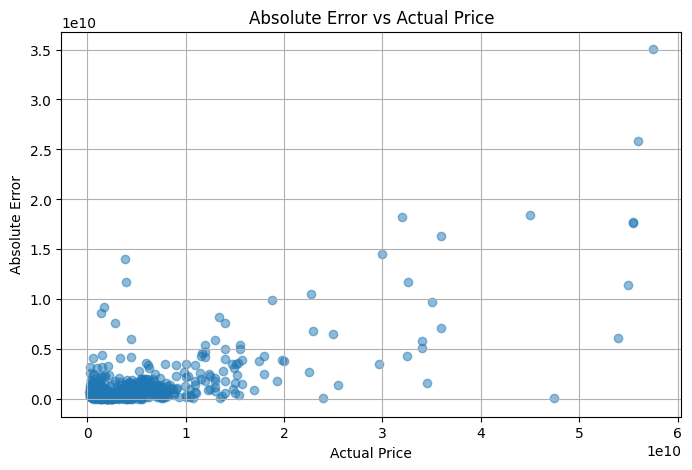

In [19]:
plt.figure(figsize=(8,5))
plt.scatter(y_test_real, abs_errors, alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Absolute Error')
plt.title('Absolute Error vs Actual Price')
plt.grid(True)
plt.show()

In [47]:
joblib.dump(MetaLearner, '../Models/meta_model.pkl')

joblib.dump(ElasticModels, '../Models/elastic_model.pkl')
joblib.dump(RandomForestModel, '../Models/rf_model.pkl')
joblib.dump(XGBBoostModel, '../Models/xgb_model.pkl')

joblib.dump(scaler, '../Models/scaler.pkl') 

['../Models/scaler.pkl']

In [ ]:
MetaLearner = joblib.load('../Models/meta_model.pkl')

ElasticModels = joblib.load('../Models/elastic_model.pkl')
RandomForestModel = joblib.load('../Models/rf_model.pkl')
XGBBoostModel = joblib.load('../Models/xgb_model.pkl')

scaler = joblib.load('../Models/scaler.pkl')

X_new = ...  #new Data

X_new_scaled = scaler.transform(X_new)

elastic_preds = ElasticModels.predict(X_new_scaled)
rf_preds = RandomForestModel.predict(X_new_scaled)
xgb_preds = XGBBoostModel.predict(X_new_scaled)


meta_features = np.column_stack((elastic_preds, rf_preds, xgb_preds))


final_preds = MetaLearner.predict(meta_features)


print(final_preds)

In [ ]:
base_models = [
    ('ElasticNet', ElasticNet(alpha=1.0,l1_ratio=0.4)),
    ('rf', RandomForestRegressor(n_estimators=80, max_depth=8)),
    ('knn', xg.XGBRegressor(n_estimators=260,max_depth=5,learning_rate=0.1,subsample=0.6,colsample_bytree=0.8,objective='reg:squarederror',eval_metric='rmse'))
]

meta_model =Ridge(alpha=1.0)

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model
)

stacked_model.fit(X_train_scaler, y_train)

# پیش‌بینی
y_pred = stacked_model.predict(X_test_scaler)


print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

print(f"Mean Squared Error (MSE): {final_mse:.2f}")

MSE: 1.0581712436536048e+19
R2 Score: 0.8177892767051933
